# Pytorch 操作介紹: 利用pytorch建立MLP和CNN進行MNIST分類模型

## MNIST資料介紹
MNIST(Modified National Institute of Standards and Technology database): http://yann.lecun.com/exdb/mnist/ 是Yann LeCun團隊整合出來的一個手寫數字資料庫，因為內含70000張手寫數字的圖片(60,000訓練圖片和10,000張測試圖片)，在早期電腦辨識出來的時候，算是公開的一個大數據。
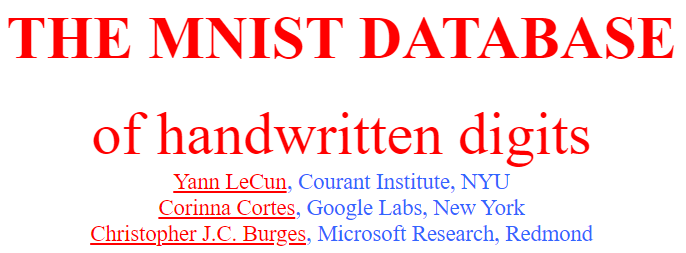
很多研究團隊都會用這個影像資料庫來做演算法的開發，因為他是公開數據，所以不同演算法之間可以利用此數據來比較演算法的好壞，在[MNIST的官網](http://yann.lecun.com/exdb/mnist/)上也可以看到採用不同演算法在此資料庫的測試集(Test set)錯誤率。
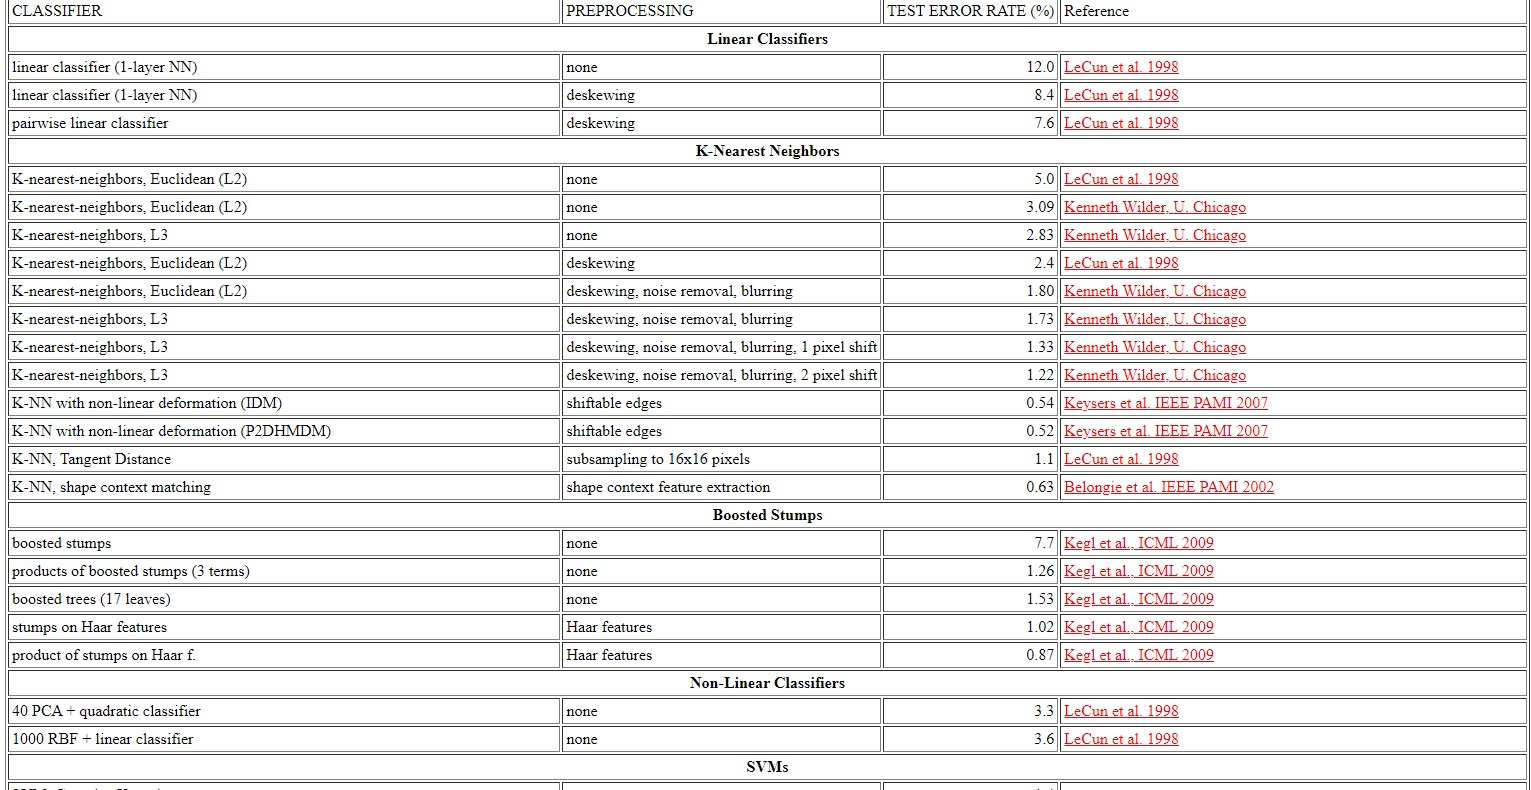


MNIST只有一個每張圖片都是$28 \times 28$大小的8bits(0~255)灰階影像，見下圖
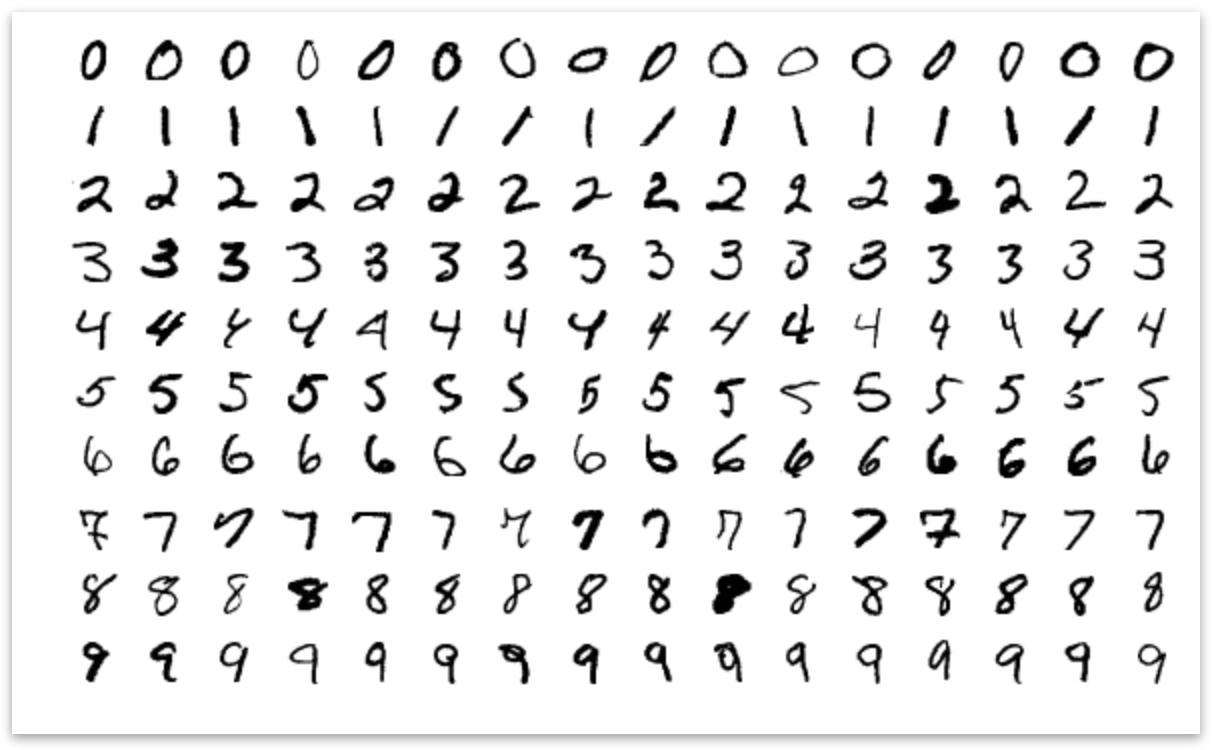

目標任務為辨識每一張圖片的數字，有0,1,2,3,4,5,6,7,8,9，共十個類別。<br>
每個類別訓練資料6000張，測試資料1000張。<br>

|類別|訓練張數|測試張數|類別|訓練張數|測試張數|
|:-|:-|:-|:-|:-|:-|
|0|6000|1000|1|6000|1000|
|2|6000|1000|3|6000|1000|
|4|6000|1000|5|6000|1000|
|6|6000|1000|7|6000|1000|
|8|6000|1000|9|6000|1000|


> 其目標就是進行圖像分類任務，因為他圖片小，資料也不算少，因此很適合在課程當作影像任務的教材使用。
相關的影像分類任務都可以以此教材作為基礎去修改成自己的資料來使用。


### pytorch預設的torchvision模組可以協助下載資料。

如果電腦內沒有下載好的資料，可用pytorch的模組同時下載和訓練。

```torchvision.datasets.MNIST(ROOT, train=True, download=True)```<br> 
ROOT:資料放置的位置，如你電腦還沒有資料，後面參數打開會會將資料下載到你設定的位置。<br> 
train: ```True```:擷取訓練的資料60000張圖。```False```:擷取測試的資料10000張圖。<br> 
download: ```True```:如果你的路徑內沒有資料，則會開始下載資料到你指定的路徑。```False```:去你指定的路徑讀入資料。

In [1]:
import torchvision 
dataset_train_MNIST = torchvision.datasets.MNIST('./dataset', train=True, download=True)
dataset_test_MNIST = torchvision.datasets.MNIST('./dataset', train=False, download=True)
print(dataset_train_MNIST)
print(dataset_test_MNIST)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./dataset
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./dataset
    Split: Test


我們可以
利用.classes來看這個資料有什麼類別的資料。<br>
利用.data來看這個影像。<br>
利用.targets來看這個資料的類別。<br>

In [2]:
dataset_train_MNIST.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [3]:
print(dataset_train_MNIST.data.shape)
print(dataset_train_MNIST.targets[0])
dataset_train_MNIST.data[0,:,:]

torch.Size([60000, 28, 28])
tensor(5)


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

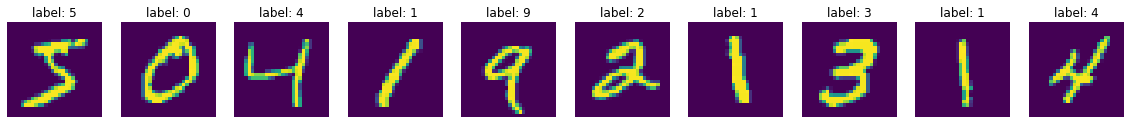

In [4]:
import matplotlib.pyplot as plt
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 10))
for ax, image, label in zip(axes, dataset_train_MNIST.data, dataset_train_MNIST.targets):
    ax.set_axis_off()
    ax.imshow(image)
    ax.set_title('label: %i' % label)

## 利用pytorch建立MLP和CNN進行MNIST分類模型¶

Pytorch訓練流程<br>

0. 是否使用CUDA <br>
1. 讀資料(dataset和dataloader)<br> 
2. 模型宣告 <br> 
3. 宣告/建立loss function<br>
4. 建立模型的參數最佳化器 <br>
5. 模型開始訓練 <br>

6. 模型儲存 <br>
7. 模型Inference <br>

#### 0.是否使用CUDA
宣告一個device決定CPU或是GPU運算

In [5]:
import torch
use_cuda=1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
print(device)

cpu


#### 1. 讀資料(dataset和dataloader)

這邊是利用torchvision的模組將MNIST dataset帶入<br>
並且利用torch.utils.data.DataLoader進行dataloader<br>
詳細內容前面破解章節已經提過了<br>

torch.Size([10, 1, 28, 28])
torch.Size([10, 784])


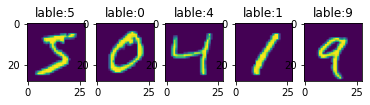

In [6]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
transform = transforms.ToTensor()
dataset_MNIST_tensor = datasets.MNIST('./dataset', train=True, download=False, transform=transform)
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=10)
for data in mnistdata_loader:
    image, label = data
    print(image.shape)
    print(image.view(-1,28*28).shape)
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(image[i,0,:,:])
        plt.title('lable:{}'.format(label[i]))
    plt.show()
    break

#### 2. 模型宣告
這邊在宣告你要用什麼神經網路，自己兜得或是開源模型都可以<br>

**1. Multi-layer perceptron (MLP)**<br>

這邊我們用一個三層Hidden layer<br>
因為全連接層圖片須拉成1D array，所以28x28的手寫圖片需要轉換成一個28x28=784的一維陣列<br>
所以神經網路的結構為<br>

|層|數量|
|:-:|:-:|
|輸入層|784(28x28)|
|隱藏層1(全連結層+激活函數ReLU)|32|
|隱藏層2(全連結層+激活函數ReLU)|32|
|隱藏層3(全連結層+激活函數ReLU)|32|
|輸出層(全連結層+正規化技術Dropout)|10|

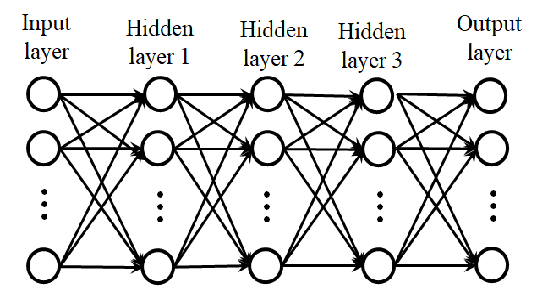


In [7]:
import torch.nn as nn
# define NN architecture
class MLP(nn.Module):
    def __init__(self, n_class=10):
        super(MLP,self).__init__()
        self.mlp = torch.nn.Sequential(
            nn.Linear(28*28, 32),
            torch.nn.ReLU(),
            nn.Linear(32, 32),
            torch.nn.ReLU(),
            nn.Linear(32, 32),
            torch.nn.ReLU(),
            nn.Dropout(0.2), 
            nn.Linear(32, n_class),
            )
    def forward(self,x):
        # flatten image input
        x = self.mlp(x)
        return x
    
model_mlp = MLP()
print(model_mlp)



MLP(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=32, out_features=10, bias=True)
  )
)


**2. 卷積神經網絡(Convolutional Neural Network，CNN)**

這邊我們用一個3層的CNN </br>
每一個卷積層都會採用Conv. + BN + ReLU的結構</br>

|層|channel數量(kernel size)|特徵圖大小(channelx寬x高)|
|:-:|:-:|:-:|
|輸入層|1|1x28x28|
|卷積層1|16(ks=3x3, stride=1, padding=1)|16x28x28|
|卷積層2|32(ks=3x3, stride=1, padding=1)|32x28x28|
|卷積層3|16(ks=3x3, stride=1, padding=1)|16x28x28|
|GAP||16x1x1|
|輸出層(全連結層)|10|10|
            
>> GAP: global average pooling


In [8]:
class ConvM(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(ConvM, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )
        
class ConvNet(nn.Module):
    
    def __init__(self, n_class=10):
        super(ConvNet, self).__init__()
        
        self.cnn = nn.Sequential(           
            ConvM(1, 16, 3, 1),
            ConvM(16, 32, 3, 1),
            ConvM(32, 16, 3, 1),
        )        
        self.fc = nn.Linear(16, n_class)
    def forward(self, x):
        # x: batch* channel * w * h
        x = self.cnn(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        output = self.fc(x)
        return output

# initialize the ConvNet
model_cnn = ConvNet()
print(model_cnn)

ConvNet(
  (cnn): Sequential(
    (0): ConvM(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): ConvM(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): ConvM(
      (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (fc): Linear(in_features=16, out_features=10, bias=True)
)


#### 3.loss function宣告

這邊我們用到的是cross entropy作為loss function，細節可以看另一個解鎖章節。<br>


In [9]:
loss = torch.nn.CrossEntropyLoss()

#### 4. optimator宣告

這個步驟是在看我們模型更新需要改用什麼樣的演算法<br>
例如: SGD, Adagrad, RMSprop, Adam, LBFGS等。<br>
reference: https://pytorch.org/docs/stable/optim.html

In [10]:
import torch.optim as optim
# optimizer = optim.Adam(model.parameters(), lr=0.01)
# optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer_cnn = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.9)
optimizer_mlp = optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.9)

### 5. 模型開始訓練

In [11]:
import PIL.Image as Image

# transform = transforms.ToTensor()
# transform = transforms.Compose([
#             transforms.RandomRotation(degrees=(-30, 30), fill=(0,), resample=Image.BICUBIC, expand=False),
#             transforms.ToTensor()
#             ])

dataset_train = datasets.MNIST('./dataset', train=True, download=False, transform=transforms.ToTensor())
dataset_test = datasets.MNIST('./dataset', train=False, download=False, transform=transforms.ToTensor())
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128)

model_mlp = MLP().to(device)
model_cnn = ConvNet().to(device)
loss = torch.nn.CrossEntropyLoss().to(device)
# optimizer_cnn = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.9)
# optimizer_mlp = optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.9)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.01)
optimizer_mlp = optim.Adam(model_mlp.parameters(), lr=0.01)
plt_loss_mlp,plt_loss_cnn=[],[]
plt_acc_mlp,plt_acc_cnn=[],[]

for epoch in range(20):
    # train
    model_cnn.train()
    model_mlp.train()
    for batch_idx, (data, target) in enumerate(dataloader_train):
        data, target = data.to(device), target.to(device)
        # MLP     
        output_mlp = model_mlp(data.view(-1,28*28)) # batch * 10
        loss_mlp=loss(output_mlp,target) # batch * n_class, target: batch    
        optimizer_mlp.zero_grad()
        loss_mlp.backward()
        optimizer_mlp.step()
        
        # CNN
        model_cnn.zero_grad()
        output_cnn = model_cnn(data)
        loss_cnn=loss(output_cnn,target)
        loss_cnn.backward()
        optimizer_cnn.step()
        
        if batch_idx % 50 ==0 :
            print('MLP Train Epoch: {} [{}/{} ]\tLoss: {:.6f}'.format(
                    epoch, 
                    batch_idx * len(data), 
                    len(dataloader_train.dataset),
                    loss_mlp.item()))
            print('CNN Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(dataloader_train.dataset), loss_cnn.item()))
                   
    # Test
    model_cnn.eval()
    model_mlp.eval()
    test_loss_mlp,  test_loss_cnn= 0, 0
    correct_mlp, correct_cnn = 0, 0
    with torch.no_grad():
        for data, target in dataloader_test:
            data, target = data.to(device), target.to(device)
             # MLP
            output_mlp = model_mlp(data.view(-1,28*28))
            test_loss_mlp += loss(output_mlp, target)
            pred_mlp = output_mlp.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct_mlp += pred_mlp.eq(target.view_as(pred_mlp)).sum().item()
            # CNN
            output_cnn = model_cnn(data)
            test_loss_cnn += loss(output_cnn, target)
            pred_cnn = output_cnn.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct_cnn += pred_cnn.eq(target.view_as(pred_cnn)).sum().item()
            
    
    test_loss_mlp /= len(dataloader_test.dataset)
    test_loss_cnn /= len(dataloader_test.dataset)
    print('MLP Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss_mlp, correct_mlp, len(dataloader_test.dataset),
        100. * correct_mlp / len(dataloader_test.dataset)))
    print('CNN Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss_cnn, correct_cnn, len(dataloader_test.dataset),
        100. * correct_cnn / len(dataloader_test.dataset)))
    plt_loss_mlp.append(test_loss_mlp)    
    plt_loss_cnn.append(test_loss_cnn)
    plt_acc_mlp.append(correct_mlp / len(dataloader_test.dataset))    
    plt_acc_cnn.append(correct_cnn / len(dataloader_test.dataset))

MLP Train Epoch: 0 [0/60000 ]	Loss: 2.308328
CNN Train Epoch: 0 [0/60000]	Loss: 2.340946
MLP Train Epoch: 0 [6400/60000 ]	Loss: 0.436557
CNN Train Epoch: 0 [6400/60000]	Loss: 1.726117
MLP Train Epoch: 0 [12800/60000 ]	Loss: 0.426836
CNN Train Epoch: 0 [12800/60000]	Loss: 1.215075
MLP Train Epoch: 0 [19200/60000 ]	Loss: 0.340549
CNN Train Epoch: 0 [19200/60000]	Loss: 0.797160
MLP Train Epoch: 0 [25600/60000 ]	Loss: 0.447571
CNN Train Epoch: 0 [25600/60000]	Loss: 0.556546
MLP Train Epoch: 0 [32000/60000 ]	Loss: 0.227555
CNN Train Epoch: 0 [32000/60000]	Loss: 0.592115
MLP Train Epoch: 0 [38400/60000 ]	Loss: 0.231937
CNN Train Epoch: 0 [38400/60000]	Loss: 0.374368
MLP Train Epoch: 0 [44800/60000 ]	Loss: 0.216393
CNN Train Epoch: 0 [44800/60000]	Loss: 0.298651
MLP Train Epoch: 0 [51200/60000 ]	Loss: 0.197683
CNN Train Epoch: 0 [51200/60000]	Loss: 0.281656
MLP Train Epoch: 0 [57600/60000 ]	Loss: 0.362641
CNN Train Epoch: 0 [57600/60000]	Loss: 0.313911
MLP Test set: Average loss: 0.0016, Accu

MLP Train Epoch: 7 [44800/60000 ]	Loss: 0.232783
CNN Train Epoch: 7 [44800/60000]	Loss: 0.239388
MLP Train Epoch: 7 [51200/60000 ]	Loss: 0.091582
CNN Train Epoch: 7 [51200/60000]	Loss: 0.102417
MLP Train Epoch: 7 [57600/60000 ]	Loss: 0.134258
CNN Train Epoch: 7 [57600/60000]	Loss: 0.074567
MLP Test set: Average loss: 0.0012, Accuracy: 9618/10000 (96%)
CNN Test set: Average loss: 0.0024, Accuracy: 8986/10000 (90%)

MLP Train Epoch: 8 [0/60000 ]	Loss: 0.040446
CNN Train Epoch: 8 [0/60000]	Loss: 0.154239
MLP Train Epoch: 8 [6400/60000 ]	Loss: 0.174480
CNN Train Epoch: 8 [6400/60000]	Loss: 0.056243
MLP Train Epoch: 8 [12800/60000 ]	Loss: 0.041025
CNN Train Epoch: 8 [12800/60000]	Loss: 0.085477
MLP Train Epoch: 8 [19200/60000 ]	Loss: 0.081808
CNN Train Epoch: 8 [19200/60000]	Loss: 0.041909
MLP Train Epoch: 8 [25600/60000 ]	Loss: 0.144322
CNN Train Epoch: 8 [25600/60000]	Loss: 0.051015
MLP Train Epoch: 8 [32000/60000 ]	Loss: 0.126116
CNN Train Epoch: 8 [32000/60000]	Loss: 0.073225
MLP Train 

MLP Train Epoch: 15 [6400/60000 ]	Loss: 0.079304
CNN Train Epoch: 15 [6400/60000]	Loss: 0.079662
MLP Train Epoch: 15 [12800/60000 ]	Loss: 0.051598
CNN Train Epoch: 15 [12800/60000]	Loss: 0.017074
MLP Train Epoch: 15 [19200/60000 ]	Loss: 0.118888
CNN Train Epoch: 15 [19200/60000]	Loss: 0.100676
MLP Train Epoch: 15 [25600/60000 ]	Loss: 0.094927
CNN Train Epoch: 15 [25600/60000]	Loss: 0.052856
MLP Train Epoch: 15 [32000/60000 ]	Loss: 0.074923
CNN Train Epoch: 15 [32000/60000]	Loss: 0.148538
MLP Train Epoch: 15 [38400/60000 ]	Loss: 0.055948
CNN Train Epoch: 15 [38400/60000]	Loss: 0.081805
MLP Train Epoch: 15 [44800/60000 ]	Loss: 0.070523
CNN Train Epoch: 15 [44800/60000]	Loss: 0.124134
MLP Train Epoch: 15 [51200/60000 ]	Loss: 0.205245
CNN Train Epoch: 15 [51200/60000]	Loss: 0.067185
MLP Train Epoch: 15 [57600/60000 ]	Loss: 0.067937
CNN Train Epoch: 15 [57600/60000]	Loss: 0.061082
MLP Test set: Average loss: 0.0013, Accuracy: 9628/10000 (96%)
CNN Test set: Average loss: 0.0012, Accuracy: 95

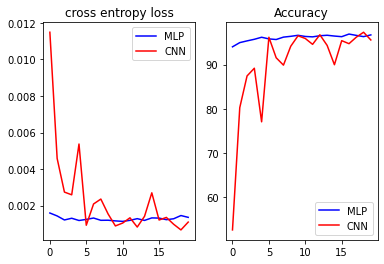

In [12]:
import numpy as np
plt.figure
plt.subplot(1,2,1)
plt.plot(plt_loss_mlp,'b')
plt.plot(plt_loss_cnn,'r')
plt.legend(['MLP','CNN'])
plt.title('cross entropy loss')
plt.subplot(1,2,2)
plt.plot(np.array(plt_acc_mlp)*100,'b')
plt.plot(np.array(plt_acc_cnn)*100,'r')
plt.legend(['MLP','CNN'])
plt.title('Accuracy')
plt.show()

#### 6. 模型儲存

In [13]:
model_mlp.eval() 
torch.save(model_mlp,'model_mlp.pth')
model_cnn.eval() 
torch.save(model_cnn,'model_cnn.pth')

> 特別需要注意，模型儲存後儲存了模型的權重(參數)<br>
但PyTorch有個很大的缺點，就是你訓練完模型後，假設有全部關掉，下一次重新要Inference模型的時候，你要load模型權重
需要有有你訓練模型的模型架構宣告。<br>
見下範例<br>

In [1]:
import torch
model_cnn = torch.load('model_cnn.pth')

AttributeError: Can't get attribute 'ConvNet' on <module '__main__'>

In [2]:
import torch
import torch.nn as nn
class ConvM(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(ConvM, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )   
class ConvNet(nn.Module):
    def __init__(self, n_class=10):
        super(ConvNet, self).__init__()
        self.cnn = nn.Sequential(           
            ConvM(1, 16, 3, 1),
            ConvM(16, 32, 3, 1),
            ConvM(32, 16, 3, 1),
        )        
        self.fc = nn.Linear(16, n_class)
    def forward(self, x):
        # x: batch* channel * w * h
        x = self.cnn(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        output = self.fc(x)
        return output
model_cnn = ConvNet()
model_cnn = torch.load('model_cnn.pth')

In [3]:
import torch.nn as nn
# define NN architecture
class MLP(nn.Module):
    def __init__(self, n_class=10):
        super(MLP,self).__init__()
        self.mlp = torch.nn.Sequential(
            nn.Linear(28*28, 32),
            torch.nn.ReLU(),
            nn.Linear(32, 32),
            torch.nn.ReLU(),
            nn.Linear(32, 32),
            torch.nn.ReLU(),
            nn.Dropout(0.2), 
            nn.Linear(32, n_class),
            )
    def forward(self,x):
        # flatten image input
        x = self.mlp(x)
        return x
model_mlp = MLP()
model_mlp = torch.load('model_mlp.pth')

#### 7. 模型Inference: 利用Pytorch和儲存的模型，Inference結果

--------------------------------------------------


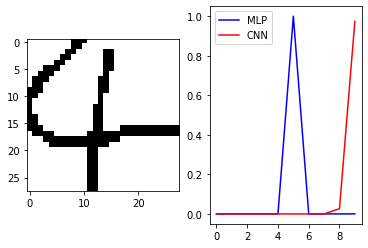

Output(MLP):5
Output(CNN):9
--------------------------------------------------


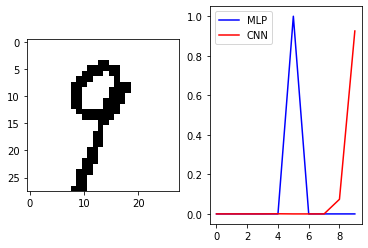

Output(MLP):5
Output(CNN):9
--------------------------------------------------


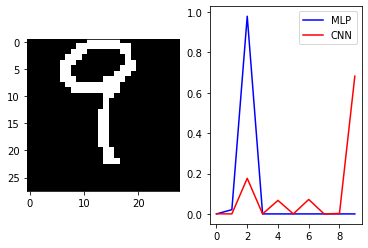

Output(MLP):2
Output(CNN):9
--------------------------------------------------


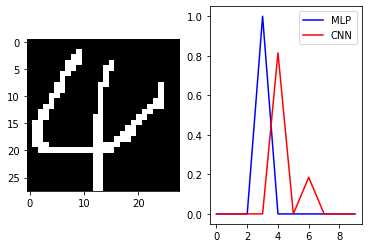

Output(MLP):3
Output(CNN):4
--------------------------------------------------


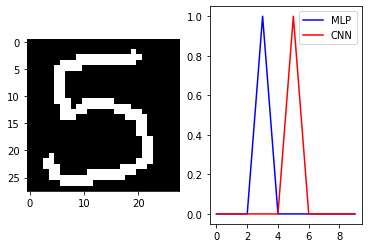

Output(MLP):3
Output(CNN):5


In [4]:
import PIL.Image as Image
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

for image_name in ['4.png','9.png','9-1.png','4-1.png','5-1.png']:
    print('-'*50)
    image = Image.open(image_name, mode='r')
    image = image.convert('1')
    image = image.resize((28,28),Image.BICUBIC )
    
    image_tensor = transforms.ToTensor()(image) #1x28x28
    image_tensor = image_tensor.unsqueeze(0) # 1x1x28x28

    model_mlp = model_mlp.to(torch.device("cpu"))
    model_mlp.eval()
    with torch.no_grad():
        outputs_MLP = model_mlp(image_tensor.view(-1,28*28)) # 1x784
    outputs_MLP = torch.exp(outputs_MLP)
    outputs_MLP /=torch.sum(outputs_MLP)
    
    model_cnn = model_cnn.to(torch.device("cpu"))
    model_cnn.eval()
    with torch.no_grad():
        outputs_CNN = model_cnn(image_tensor) # 1x1x28x28
    outputs_CNN = torch.exp(outputs_CNN)
    outputs_CNN /=torch.sum(outputs_CNN)
    
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.plot(outputs_MLP[0],'b')
    plt.plot(outputs_CNN[0],'r')    
    plt.legend(['MLP','CNN'])
    plt.show()
    print("Output(MLP):{}".format(torch.argmax(outputs_MLP[0])))
    print("Output(CNN):{}".format(torch.argmax(outputs_CNN[0])))
